In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv(r'D:\Jupyter Notebook\SVM\krkopt.data', header=None)   # 读取数据
data.dropna(inplace=True)  # 删除有缺失值的行

# 将样本数值化，将第0、2、4位的字母a~h分别替换为数字0~7
for i in [0,2,4]:
    data.loc[data[i]=='a',i] = 0
    data.loc[data[i]=='b',i] = 1
    data.loc[data[i]=='c',i] = 2
    data.loc[data[i]=='d',i] = 3
    data.loc[data[i]=='e',i] = 4
    data.loc[data[i]=='f',i] = 5
    data.loc[data[i]=='g',i] = 6
    data.loc[data[i]=='h',i] = 7
    
# 将标签数值化
data.loc[data[6]!='draw', 6] = -1    # 选择第6列中值不等于'draw'的行
data.loc[data[6]=='draw', 6] = 1

# 拆分训练集和测试集：train_test_split(x, y, test_size, random_state)
X_train, X_test, y_train, y_test =  train_test_split(data.iloc[:,:6], data[6].astype("int").values, test_size=0.82178500142572, random_state=42)  # (28056-5000)/28056

In [3]:
# 计算训练集的均值和方差
train_mean = X_train.mean(axis=0)
train_std = X_train.std(axis=0)

# 对训练集和测试集进行归一化处理
X_train = (X_train - train_mean) / train_std
X_test = (X_test - train_mean) / train_std

In [4]:
# 寻找C和gamma的粗略范围（第一次迭代）
CScale = [i for i in range(-5, 16, 2)];
gammaScale = [i for i in range(-15, 4, 2)];
cv_scores = 0

for i in CScale:
    for j in gammaScale:
        model = SVC(kernel = 'rbf', C = 2**i, gamma = 2**j)   # rbf即为高斯核
        scores = cross_val_score(model, X_train, y_train, cv = 5, scoring = 'accuracy')  # cv=5表示5折交叉验证
        if scores.mean() > cv_scores:
            cv_scores = scores.mean()
            savei = i
            savej = j
            
# 找到更精确的C和gamma（第二次迭代）
CScale = [i for i in np.arange(savei-2, savei+2+0.4, 0.4)];
gammaScale = [i for i in np.arange(savej-2, savej+2+0.4, 0.4)];
cv_scores = 0

for i in CScale:
    for j in gammaScale:
        model = SVC(kernel = 'rbf', C = 2**i,gamma=2**j)
        scores = cross_val_score(model, X_train, y_train, cv = 5, scoring = 'accuracy')
        if scores.mean() > cv_scores:
            cv_scores = scores.mean()
            savei = i
            savej = j

In [5]:
# 将确定好的参数重新建立svm模型
model = SVC(kernel = 'rbf', C=2**savei, gamma=2**savej, probability=True)
model.fit(X_train, y_train)
pre_label = model.predict(X_test)   # 预测标签
probas = model.predict_proba(X_test)   # 预测样本属于各个类别的概率估计值
pre = probas[:, 1]   # 取第二列的概率作为预测值，通常是正例的概率
model.score(X_test, y_test)

0.9934941013185288

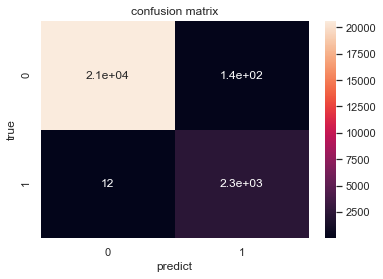

<Figure size 432x288 with 0 Axes>

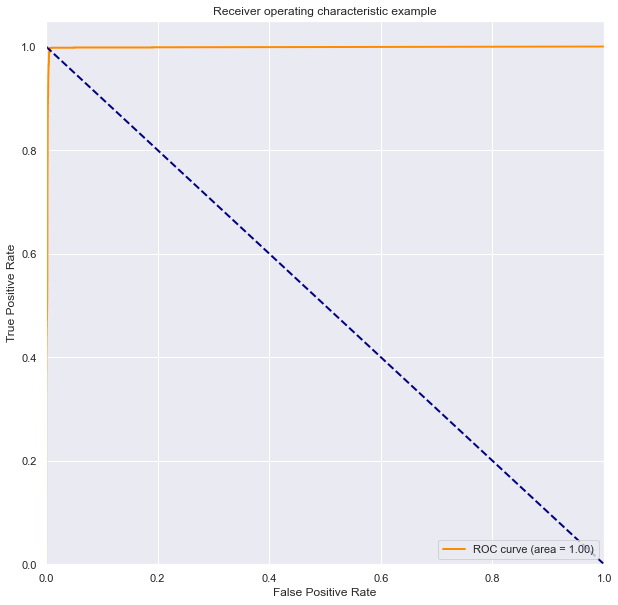

In [6]:
# 绘制AUC和EER图形
'''
官方文档用法：
sklearn.metrics.confusion_matrix(y_true, y_pred, labels=None, sample_weight=None)
y_true: 是样本真实分类结果
y_pred: 是样本预测分类结果
labels：是所给出的类别，通过这个可对类别进行选择
sample_weight: 样本权重
'''
cm = confusion_matrix(y_test, pre_label, labels=[-1, 1], sample_weight=None)

sns.set()  # 设置风格
f, ax = plt.subplots()   # 建立一个figure对象和一个axis对象
sns.heatmap(cm, annot=True, ax=ax)  # 画热力图。annot=True显示每个单元格的数值
ax.set_title('confusion matrix')  # 标题
ax.set_xlabel('predict')  # x轴
ax.set_ylabel('true')  # y轴
fpr, tpr, threshold = roc_curve(y_test, pre)  # 计算真正率tpr和假正率fpr
roc_auc = auc(fpr,tpr)  # 计算auc的值，auc就是曲线包围的面积，越大越好

plt.figure()  # 新建画图板
lw = 2  # lw指折线图的线条宽度
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) # 假正率为横坐标，真正率为纵坐标做ROC曲线
plt.plot([0, 1], [1, 0], color='navy', lw=lw, linestyle='--')  # EER
plt.xlim([0.0, 1.0])  # x轴的作图范围
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")  # 图例显示在右下角
plt.show()

In [7]:
roc_auc

0.9974848387037987

### 博客：https://zhuanlan.zhihu.com/p/537715035